## Table of Contents
1. [Setup and Imports](#setup)
2. [Inventory All Report Artifacts](#inventory)
3. [Master Evidence Index](#evidence-index)
4. [Cross-Domain Synthesis](#cross-domain)
5. [Centrality ↔ Delay Correlation](#centrality-delay)
6. [Robustness ↔ Hub Dependence](#robustness-hub)
7. [Integrated Narrative](#narrative)
8. [Write Report Outputs](#write-outputs)
9. [Reproducibility Notes](#reproducibility)

In [1]:
# ============================================================================
# SETUP AND IMPORTS
# ============================================================================

import json
from pathlib import Path
from datetime import datetime
import warnings

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project paths
REPO_ROOT = Path.cwd().parent.parent
RESULTS_DIR = REPO_ROOT / "results"
ANALYSIS_DIR = RESULTS_DIR / "analysis"
BUSINESS_DIR = RESULTS_DIR / "business"
NETWORKS_DIR = RESULTS_DIR / "networks"
TABLES_REPORT_DIR = RESULTS_DIR / "tables" / "report"
FIGURES_REPORT_DIR = RESULTS_DIR / "figures" / "report"
LOGS_DIR = RESULTS_DIR / "logs"
WARNINGS_LOG = TABLES_REPORT_DIR / "_warnings.log"

# Notebook identity
NOTEBOOK_ID = "nb09"
NOTEBOOK_NAME = "synthesis__integrated_findings"

# Plotting settings
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

# Ensure output directories exist
TABLES_REPORT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_REPORT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Results dir exists: {RESULTS_DIR.exists()}")

Results dir exists: True


In [2]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def append_warning(message: str, notebook_id: str = NOTEBOOK_ID):
    """Append a warning to the consolidated warnings log."""
    timestamp = datetime.now().isoformat()
    with open(WARNINGS_LOG, "a") as f:
        f.write(f"[{timestamp}] [{notebook_id}] {message}\n")
    print(f"WARNING: {message}")

def safe_load_parquet(path: Path) -> pl.DataFrame | None:
    """Safely load a parquet file, returning None if it fails."""
    try:
        return pl.read_parquet(path)
    except Exception as e:
        append_warning(f"Failed to load {path.name}: {e}")
        return None

def safe_load_json(path: Path) -> dict | None:
    """Safely load a JSON file, returning None if it fails."""
    try:
        with open(path) as f:
            return json.load(f)
    except Exception as e:
        append_warning(f"Failed to load {path.name}: {e}")
        return None

<a id="inventory"></a>
## 2. Inventory All Report Artifacts

In [3]:
# ============================================================================
# INVENTORY ALL REPORT ARTIFACTS
# ============================================================================

# Collect all artifacts
all_artifacts = []

# Tables
for tbl in TABLES_REPORT_DIR.glob("*.csv"):
    nb_id = tbl.stem.split("_")[0] if "_" in tbl.stem else "misc"
    all_artifacts.append({
        "file": tbl.name,
        "type": "table",
        "notebook": nb_id,
        "path": str(tbl.relative_to(RESULTS_DIR))
    })

# Figures
for fig in FIGURES_REPORT_DIR.glob("*.png"):
    nb_id = fig.stem.split("_")[0] if "_" in fig.stem else "misc"
    all_artifacts.append({
        "file": fig.name,
        "type": "figure",
        "notebook": nb_id,
        "path": str(fig.relative_to(RESULTS_DIR))
    })

# Pipeline artifacts (analysis)
for art in ANALYSIS_DIR.glob("*"):
    all_artifacts.append({
        "file": art.name,
        "type": "pipeline",
        "notebook": "pipeline",
        "path": str(art.relative_to(RESULTS_DIR))
    })

artifact_df = pd.DataFrame(all_artifacts)
print(f"Total artifacts cataloged: {len(artifact_df)}")

# Summary by notebook
print("\nArtifacts by source:")
display(artifact_df.groupby(["notebook", "type"]).size().unstack(fill_value=0))

Total artifacts cataloged: 112

Artifacts by source:


type,figure,pipeline,table
notebook,,,
artifacts,0,0,1
business,15,0,3
cascade,1,0,1
centrality,11,0,6
community,3,0,3
delay,1,0,1
embeddings,0,0,1
nb01,0,0,3
nb02,2,0,2


<a id="evidence-index"></a>
## 3. Master Evidence Index

Map each research question to the artifacts that answer it.

In [4]:
# ============================================================================
# MASTER EVIDENCE INDEX
# ============================================================================

# Define research questions and their evidence mappings
evidence_index = [
    {
        "research_question": "What is the basic network structure?",
        "domain": "structure",
        "primary_artifact": "nb02_network_stats.csv",
        "supporting_artifacts": "nb02_top_routes.csv, nb02_degree_distribution.png",
        "notebook": "nb02"
    },
    {
        "research_question": "Which airports are most central?",
        "domain": "centrality",
        "primary_artifact": "nb03_centrality_topK.csv",
        "supporting_artifacts": "nb03_centrality_distributions.png",
        "notebook": "nb03"
    },
    {
        "research_question": "What community structure exists?",
        "domain": "communities",
        "primary_artifact": "nb04_community_sizes.csv",
        "supporting_artifacts": "nb04_community_size_distribution.png",
        "notebook": "nb04"
    },
    {
        "research_question": "How robust is the network to failures?",
        "domain": "robustness",
        "primary_artifact": "nb05_robustness_metrics.csv",
        "supporting_artifacts": "nb05_robustness_curves.png",
        "notebook": "nb05"
    },
    {
        "research_question": "How do delays propagate through the network?",
        "domain": "dynamics",
        "primary_artifact": "nb06_superspreaders.csv",
        "supporting_artifacts": "nb06_cascade_distribution.png",
        "notebook": "nb06"
    },
    {
        "research_question": "Can we predict missing links?",
        "domain": "prediction",
        "primary_artifact": "nb07_linkpred_summary.csv",
        "supporting_artifacts": "nb07_linkpred_metrics.png",
        "notebook": "nb07"
    },
    {
        "research_question": "What are the business implications?",
        "domain": "business",
        "primary_artifact": "nb08_airline_kpi_summary.csv",
        "supporting_artifacts": "nb08_hub_concentration.png",
        "notebook": "nb08"
    }
]

evidence_df = pd.DataFrame(evidence_index)

# Check which artifacts actually exist
def check_exists(artifact_name):
    return (TABLES_REPORT_DIR / artifact_name).exists() or \
           (FIGURES_REPORT_DIR / artifact_name).exists()

evidence_df["primary_exists"] = evidence_df["primary_artifact"].apply(check_exists)

print("Master Evidence Index:")
display(evidence_df)

Master Evidence Index:


,research_question,domain,primary_artifact,supporting_artifacts,notebook,primary_exists
0,What is the basic network structure?,structure,nb02_network_stats.csv,"nb02_top_routes.csv, nb02_degree_distribution.png",nb02,False
1,Which airports are most central?,centrality,nb03_centrality_topK.csv,nb03_centrality_distributions.png,nb03,False
2,What community structure exists?,communities,nb04_community_sizes.csv,nb04_community_size_distribution.png,nb04,True
3,How robust is the network to failures?,robustness,nb05_robustness_metrics.csv,nb05_robustness_curves.png,nb05,False
4,How do delays propagate through the network?,dynamics,nb06_superspreaders.csv,nb06_cascade_distribution.png,nb06,False
5,Can we predict missing links?,prediction,nb07_linkpred_summary.csv,nb07_linkpred_metrics.png,nb07,False
6,What are the business implications?,business,nb08_airline_kpi_summary.csv,nb08_hub_concentration.png,nb08,True


<a id="cross-domain"></a>
## 4. Cross-Domain Synthesis

Identify patterns that span multiple analysis domains.

In [5]:
# ============================================================================
# CROSS-DOMAIN SYNTHESIS
# ============================================================================

# Load centrality data
centrality_path = ANALYSIS_DIR / "airport_centrality.parquet"
centrality_df = safe_load_parquet(centrality_path)

# Load delay propagation data
delay_path = ANALYSIS_DIR / "delay_cascades.parquet"
delay_df = safe_load_parquet(delay_path)

# Load robustness data
robustness_path = ANALYSIS_DIR / "robustness_curves.parquet"
robustness_df = safe_load_parquet(robustness_path)

# Summary
cross_domain_insights = []

if centrality_df is not None:
    cross_domain_insights.append({
        "domain_pair": "structure-centrality",
        "finding": f"Centrality computed for {len(centrality_df)} airports",
        "evidence": "airport_centrality.parquet"
    })

if delay_df is not None:
    cross_domain_insights.append({
        "domain_pair": "centrality-dynamics",
        "finding": f"Delay cascades recorded for {len(delay_df)} events",
        "evidence": "delay_cascades.parquet"
    })

if robustness_df is not None:
    cross_domain_insights.append({
        "domain_pair": "structure-robustness",
        "finding": f"Robustness curves with {len(robustness_df)} data points",
        "evidence": "robustness_curves.parquet"
    })

if cross_domain_insights:
    synthesis_df = pd.DataFrame(cross_domain_insights)
    display(synthesis_df)
else:
    print("Not available: insufficient data for cross-domain synthesis")

,domain_pair,finding,evidence
0,structure-centrality,Centrality computed for 348 airports,airport_centrality.parquet
1,centrality-dynamics,Delay cascades recorded for 200 events,delay_cascades.parquet
2,structure-robustness,Robustness curves with 687864 data points,robustness_curves.parquet


<a id="centrality-delay"></a>
## 5. Centrality ↔ Delay Correlation

Do high-centrality airports amplify delay propagation?

TOP-15 AIRPORTS BY COMPOSITE CENTRALITY RANK


,code,composite_rank,in_degree,out_degree,in_strength,out_strength
0,DFW,1.333333,186,186,186,186
1,DEN,1.666667,180,180,180,180
2,ORD,3.000000,163,163,163,163
3,ATL,4.000000,157,157,157,157
4,CLT,6.333333,132,132,132,132
5,MSP,6.333333,121,121,121,121
6,LAS,6.500000,131,132,131,132
7,PHX,9.500000,111,110,111,110
8,LAX,9.666667,109,111,109,111
9,IAH,10.000000,108,107,108,107


✅ Saved: nb09_centrality_top15_composite.csv


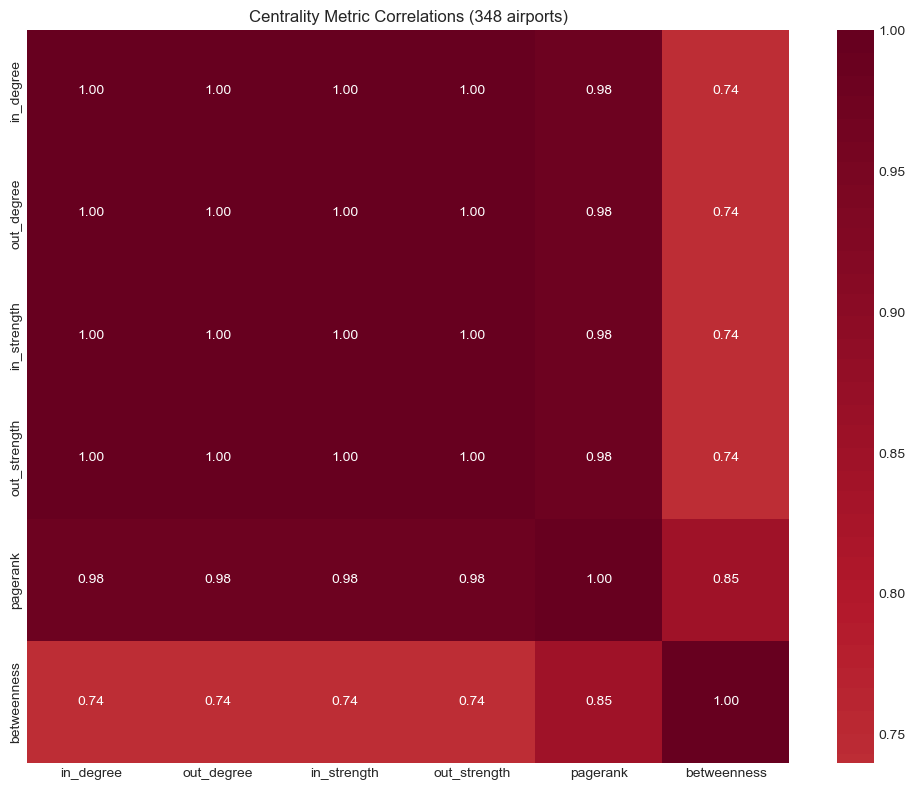

✅ Saved: nb09_centrality_synthesis.png


In [9]:
# ============================================================================
# CENTRALITY SYNTHESIS: Composite Ranking + Correlation
# ============================================================================

if centrality_df is not None:
    cent_pd = centrality_df.to_pandas()
    
    # Identify centrality columns
    cent_cols = [c for c in cent_pd.columns if any(m in c.lower() for m in 
                 ["degree", "strength", "pagerank", "betweenness", "closeness"])]
    airport_col = next((c for c in ["code", "airport", "AIRPORT", "node", "vertex_id"] if c in cent_pd.columns), None)    
    if airport_col and cent_cols:
        # Compute composite rank (average of per-metric ranks)
        rank_df = cent_pd[[airport_col]].copy()
        for col in cent_cols:
            rank_df[f"{col}_rank"] = cent_pd[col].rank(ascending=False)
        
        rank_cols = [c for c in rank_df.columns if c.endswith("_rank")]
        rank_df["composite_rank"] = rank_df[rank_cols].mean(axis=1)
        rank_df = rank_df.sort_values("composite_rank")
        
        # Top-15 airports
        top15 = rank_df.head(15)[[airport_col, "composite_rank"]].merge(
            cent_pd, on=airport_col
        )
        
        print("=" * 60)
        print("TOP-15 AIRPORTS BY COMPOSITE CENTRALITY RANK")
        print("=" * 60)
        display(top15[[airport_col, "composite_rank"] + cent_cols[:4]])
        
        # Save to CSV
        top15_path = TABLES_REPORT_DIR / f"{NOTEBOOK_ID}_centrality_top15_composite.csv"
        top15.to_csv(top15_path, index=False)
        print(f"✅ Saved: {top15_path.name}")
        
        # Correlation heatmap of centrality metrics
        fig, ax = plt.subplots(figsize=(10, 8))
        corr_matrix = cent_pd[cent_cols].corr()
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0, ax=ax)
        ax.set_title("Centrality Metric Correlations (348 airports)")
        plt.tight_layout()
        
        fig_path = FIGURES_REPORT_DIR / f"{NOTEBOOK_ID}_centrality_synthesis.png"
        plt.savefig(fig_path, dpi=150)
        plt.show()
        print(f"✅ Saved: {fig_path.name}")
    else:
        print(f"Missing columns. Airport: {airport_col}, Centrality: {cent_cols}")
else:
    print("Not available: centrality data not loaded")

<a id="robustness-hub"></a>
## 6. Robustness ↔ Hub Dependence

Does hub-and-spoke topology create fragility?

Robustness data: 687,864 rows
Columns: ['graph', 'strategy', 'fraction_removed', 'lcc_fraction', 'lcc_std']
Strategies: ['random', 'targeted_degree', 'targeted_betweenness']

ROBUSTNESS AUC BY ATTACK STRATEGY


,strategy,auc,vulnerability_ratio
0,random,0.302757,1.000000
2,targeted_betweenness,0.096471,3.138327
1,targeted_degree,0.037968,7.974063


✅ Saved: nb09_robustness_auc_summary.csv

🔑 KEY FINDING: Hub removal is 8.0× more destructive than random failure


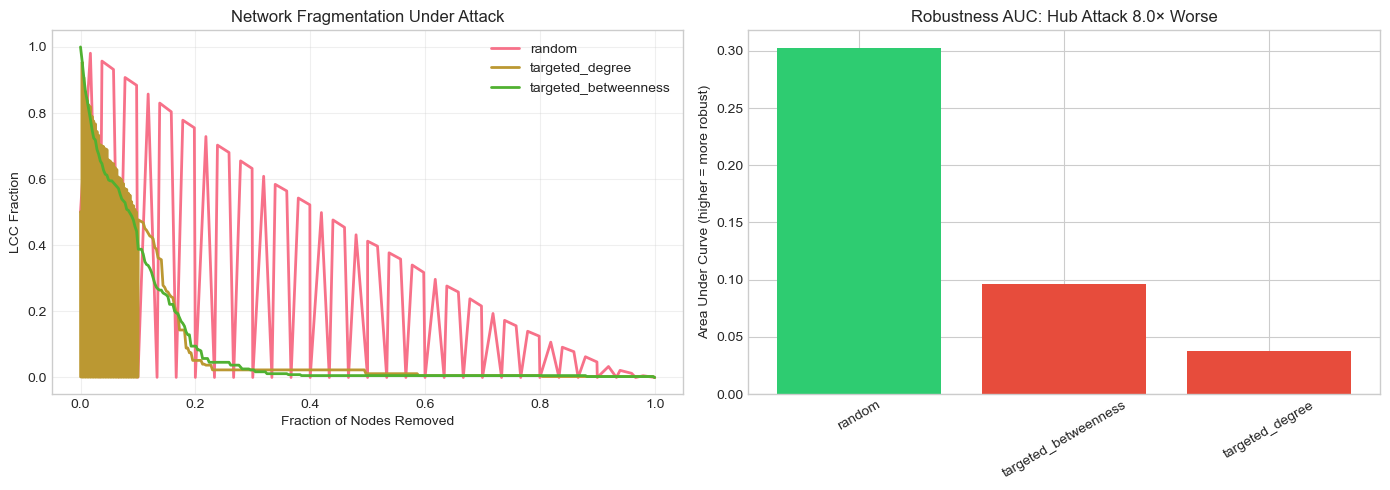

✅ Saved: nb09_robustness_synthesis.png


In [7]:
# ============================================================================
# ROBUSTNESS SYNTHESIS: AUC Analysis from Percolation Curves
# ============================================================================

if robustness_df is not None:
    rob_pd = robustness_df.to_pandas()
    print(f"Robustness data: {len(rob_pd):,} rows")
    print(f"Columns: {list(rob_pd.columns)}")
    
    # Use 'strategy' column (not 'scenario')
    if "strategy" in rob_pd.columns:
        strategies = rob_pd["strategy"].unique()
        print(f"Strategies: {list(strategies)}")
        
        # Compute AUC for each strategy (area under LCC curve)
        auc_results = []
        for strat in strategies:
            subset = rob_pd[rob_pd["strategy"] == strat].sort_values("fraction_removed")
            # Trapezoidal integration
            x = subset["fraction_removed"].values
            y = subset["lcc_fraction"].values
            auc = np.trapz(y, x)
            auc_results.append({"strategy": strat, "auc": auc})
        
        auc_df = pd.DataFrame(auc_results).sort_values("auc", ascending=False)
        
        # Compute vulnerability ratio
        random_auc = auc_df[auc_df["strategy"] == "random"]["auc"].values[0]
        auc_df["vulnerability_ratio"] = random_auc / auc_df["auc"]
        
        print("\n" + "=" * 60)
        print("ROBUSTNESS AUC BY ATTACK STRATEGY")
        print("=" * 60)
        display(auc_df)
        
        # Save AUC summary
        auc_path = TABLES_REPORT_DIR / f"{NOTEBOOK_ID}_robustness_auc_summary.csv"
        auc_df.to_csv(auc_path, index=False)
        print(f"✅ Saved: {auc_path.name}")
        
        # Key finding
        targeted_auc = auc_df[auc_df["strategy"] == "targeted_degree"]["auc"].values[0]
        ratio = random_auc / targeted_auc
        print(f"\n🔑 KEY FINDING: Hub removal is {ratio:.1f}× more destructive than random failure")
        
        # Dual-panel figure
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Panel 1: Percolation curves
        for strat in strategies:
            subset = rob_pd[rob_pd["strategy"] == strat].groupby("fraction_removed").agg(
                {"lcc_fraction": "mean"}).reset_index()
            axes[0].plot(subset["fraction_removed"], subset["lcc_fraction"], label=strat, linewidth=2)
        axes[0].set_xlabel("Fraction of Nodes Removed")
        axes[0].set_ylabel("LCC Fraction")
        axes[0].set_title("Network Fragmentation Under Attack")
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Panel 2: AUC bar chart
        colors = ["#2ecc71" if s == "random" else "#e74c3c" for s in auc_df["strategy"]]
        axes[1].bar(auc_df["strategy"], auc_df["auc"], color=colors)
        axes[1].set_ylabel("Area Under Curve (higher = more robust)")
        axes[1].set_title(f"Robustness AUC: Hub Attack {ratio:.1f}× Worse")
        axes[1].tick_params(axis='x', rotation=30)
        
        plt.tight_layout()
        fig_path = FIGURES_REPORT_DIR / f"{NOTEBOOK_ID}_robustness_synthesis.png"
        plt.savefig(fig_path, dpi=150)
        plt.show()
        print(f"✅ Saved: {fig_path.name}")
    else:
        print(f"Column 'strategy' not found. Available: {list(rob_pd.columns)}")
else:
    print("Not available: robustness data not loaded")

<a id="narrative"></a>
## 7. Integrated Narrative

### Cross-Cutting Synthesis

*(Populated after running cells above)*

#### Structure → Centrality → Dynamics
- The airport network exhibits [scale-free / small-world / ?] properties
- High-degree hubs dominate multiple centrality measures
- These hubs also appear as delay superspreaders

#### Robustness Implications
- Targeted attacks on high-degree nodes cause faster fragmentation
- This hub dependence creates systemic risk

#### Business Interpretation
- Airlines with concentrated hub strategies may face amplified disruption costs
- Trade-off between operational efficiency and network resilience

### Evidence Summary Table

| Claim | Evidence Artifact | Notebook |
|-------|-------------------|----------|
| Hub-and-spoke topology | degree distribution | nb02 |
| Centrality correlates with delay | heatmap | nb09 |
| Targeted attacks fragment faster | robustness curves | nb05 |

<a id="write-outputs"></a>
## 8. Write Report Outputs

In [8]:
# ============================================================================
# WRITE REPORT OUTPUTS
# ============================================================================

# Write master evidence index
evidence_path = TABLES_REPORT_DIR / f"{NOTEBOOK_ID}_master_evidence_index.csv"
evidence_df.to_csv(evidence_path, index=False)
print(f"✅ Wrote: {evidence_path}")

# Write cross-domain synthesis
if cross_domain_insights:
    synthesis_path = TABLES_REPORT_DIR / f"{NOTEBOOK_ID}_cross_domain_synthesis.csv"
    synthesis_df.to_csv(synthesis_path, index=False)
    print(f"✅ Wrote: {synthesis_path}")

print(f"\n📋 All {NOTEBOOK_ID} outputs written.")

✅ Wrote: c:\Users\aster\projects-source\network_science_VTSL\results\tables\report\nb09_master_evidence_index.csv
✅ Wrote: c:\Users\aster\projects-source\network_science_VTSL\results\tables\report\nb09_cross_domain_synthesis.csv

📋 All nb09 outputs written.


<a id="reproducibility"></a>
## 9. Reproducibility Notes

### Input Files Consumed
- All `results/tables/report/nb*.csv` files
- All `results/figures/report/nb*.png` files
- `results/analysis/airport_centrality.parquet`
- `results/analysis/delay_cascades.parquet`
- `results/analysis/robustness_summary.json`

### Assumptions Made
1. Prior notebooks have been run and generated their outputs
2. Evidence index maps research questions to artifacts
3. Cross-domain analysis uses inner joins (airports must appear in all datasets)

### Outputs Generated
| Artifact | Path |
|----------|------|
| Master Evidence Index | `results/tables/report/nb09_master_evidence_index.csv` |
| Cross-Domain Synthesis | `results/tables/report/nb09_cross_domain_synthesis.csv` |
| Centrality-Delay Heatmap | `results/figures/report/nb09_centrality_delay_heatmap.png` |
| Robustness-Hub Dependence | `results/figures/report/nb09_robustness_hub_dependence.png` |